### คลาสเพอร์เซปตรอนสองชั้นสำหรับจำแนกประเภทหลายกลุ่มแบบเดียวกับที่ทำในบทที่ ๘ 

In [86]:
import numpy as np
import matplotlib.pyplot as plt


In [154]:
class Affine:
    # Input : m0, Output : m1, Distribution scale : sigma
    def __init__(self, m0, m1, sigma):
        self.m = m0, m1
        self.w = np.random.normal(0, sigma, self.m)
        self.b = np.zeros(m1)
        self.gw, self.gb = 0, 0
    def forward(self, X):
        self.X = X
        return np.dot(X, self.w) + self.b
    def backward(self, g):
        self.gw += np.dot(self.X.T, g)
        self.gb += g.sum(0)
        return np.dot(g, self.w.T)

class Sigmoid:
    def forward(self, a):
        self.h = 1/(1+np.exp(-a))
        return self.h
    def backward(self, g):
        return g * (1-self.h) * self.h
    
# softmax then entropy in same function
class SoftmaxEntropy:
    def forward(self, a, Z):
        self.Z = Z
        exp_a = np.exp(a.T - a.max(1))
        self.h = (exp_a/exp_a.sum(0)).T
        return -(np.log(self.h[Z] + 1e-10)).mean()
    def backward(self, g):
        return g * (self.h - self.Z)/len(self.Z)
    
def cal_onehot(z, n):
    return z[:, None] == range(n)




class TwolayerNN:
    def __init__(self, m, eta):
        self.m, self.eta = m, eta
    def learn(self, X, z, n_learns):
        self.n_groups = int(z.max() + 1)
        Z = cal_onehot(z, self.n_groups)
        
        # Layers of NN
        self.layers = [
            Affine(X.shape[1], self.m, sigma=1),
            Sigmoid(),
            Affine(self.m, self.n_groups, 1),
            SoftmaxEntropy()
        ]
        self.entropy = []
        self.score = []
        
        for o in range(n_learns):
            # FORWARD
            a = X
            
            # not include last layer (softmaxEntropy) because it takes 2 params
            # but other first 3 layers takes 1 param
            for l in self.layers[:-1]:
                a = l.forward(a)
            # CALCULATE LOSS FROM LAST LAYER
            entropy = self.layers[-1].forward(a, Z) # last layer is SoftmaxEntropy
            self.entropy.append(entropy)
            
            
            score = (a.argmax(1) == z).mean()
            self.score.append(score)
            
            # BACKWARD PROPAGATION
            g = 1 
            # start from last layers back to first layer
            for l in reversed(self.layers):
                g = l.backward(g)
            
            # ADJUST PARAMS
            for i in [0, 2]:
                self.layers[i].w -= self.eta * self.layers[i].gw
                self.layers[i].b -= self.eta * self.layers[i].gb
                self.layers[i].gw = 0
                self.layers[i].gb = 0
    def predict(self, X):
        for l in self.layers[:-1]:
            X = l.forward(X)
        return X.argmax(1)

# Using

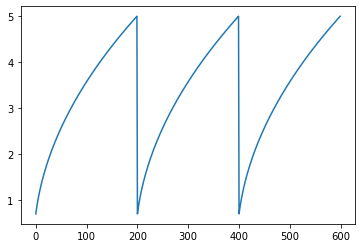

In [88]:
np.random.seed(7)
k = np.sqrt(np.linspace(0.5, 25, 200))
r = np.tile(k, 3)
plt.plot(r)

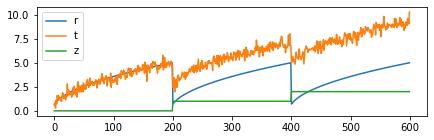

In [126]:
r = np.tile(np.sqrt(np.linspace(0.5, 25, 200)), 3)
t = np.random.normal(r, 0.4)
z = np.arange(3).repeat(200)
t += z * (np.pi/3) * 2

plt.figure(figsize=(7,2))

plt.plot(r, label='r')
plt.plot(t, label='t')
plt.plot(z ,label='z')

plt.legend()
plt.show()

(2, 600)


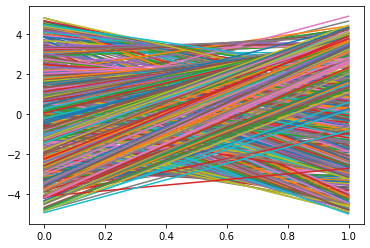

In [104]:
X = np.array([r*np.cos(t), r*np.sin(t)])
print(X.shape)
plt.plot(X)
plt.show()

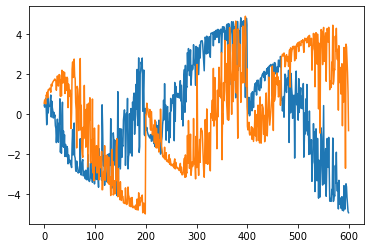

In [127]:
X = X.T
plt.plot(X)
plt.show()

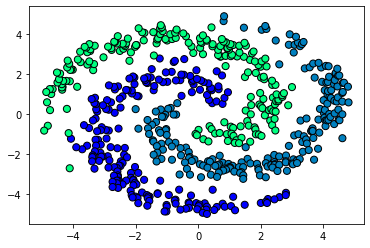

In [129]:
plt.scatter(X[:, 0], X[:, 1] ,50, c=z, edgecolor='k',
           cmap='winter')
plt.show()

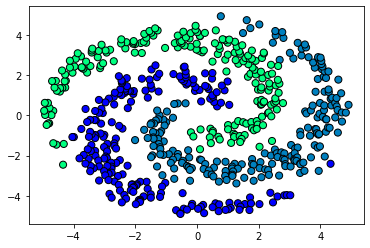

In [136]:
np.random.seed(7)
r = np.tile(np.sqrt(np.linspace(0.5,25,200)),3)
t = np.random.normal(r,0.4)
z = np.arange(3).repeat(200)
t += z*np.pi/3*2
X = np.array([r*np.cos(t),r*np.sin(t)]).T
plt.scatter(X[:,0],X[:,1],50,c=z,edgecolor='k',cmap='winter')
plt.show()

In [155]:
nn = TwolayerNN(m=47, eta=0.5)
nn.learn(X, z, n_learns=2000)

mx, my = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 200),
    np.linspace(X[:,1].min(), X[:,1].max(), 200)
)
mX = np.array([mx.ravel(), my.ravel()]).T
mz = nn.predict(mX).reshape(200, -1)


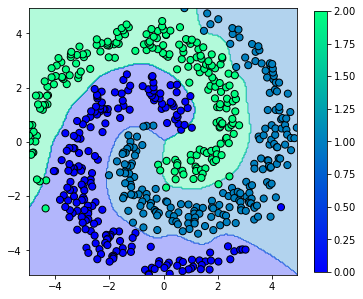

In [160]:
plt.figure(figsize=(6,6 ))
plt.axes(aspect=1, 
         xlim=(X[:,0].min(), X[:,0].max()),
        ylim=(X[:,1].min(), X[:,1].max())
        )
plt.contourf(mx, my, mz, cmap='winter', alpha=.3)
plt.scatter(X[:,0], X[:,1], 50, c=z, edgecolor='k', cmap='winter')

plt.colorbar(shrink=.8)
plt.show()

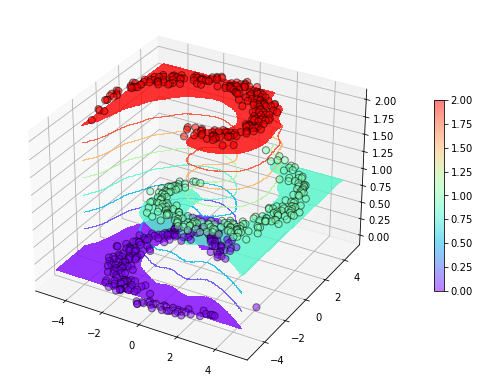

In [215]:
from mpl_toolkits import mplot3d
#fig, ax = plt.subplots(projection='3d') # ERROR IN FIGURE LEVEL
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection='3d')

# cm = plt.cm.autumn
cm = plt.cm.rainbow
ax.contourf(mx,my,mz, cmap=cm, extend='both', alpha=.8)
sct = ax.scatter(xs=X[:,0], ys=X[:,1], zs=z, s=50, c=z, cmap=cm,
          edgecolor='k', alpha=.5)
# plt.colorbar(ax=ax)

# ax.colorbar()
fig.colorbar(mappable=sct, ax=ax, shrink=.5, pad=.1)
plt.show()

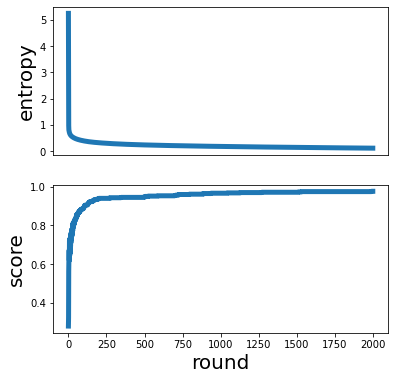

In [230]:
plt.figure(figsize=(6,6))
kw = dict(size=20)

plt.subplot(211, xticks=[])
plt.plot(nn.entropy, lw=5)
plt.ylabel('entropy', **kw)

plt.subplot(212, )
plt.plot(nn.score, lw=5)
plt.ylabel('score', **kw)

plt.xlabel('round', **kw)
plt.show()